In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import pickle
from MVDD.MVDD import MVDD
import MVDD.MVDD_Generator as mvGen

%matplotlib inline

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#HELPER CODE

#Validation Method
def performValidation(model, data, realScores, aucName):
    #MVDD Accuracy
    print("\n*****MVDD Validation*****")
    y_pred = model.predictScoreSet(data)
    y_test = realScores
    
    FP = confusion_matrix(y_test,y_pred).sum(axis=0) - np.diag(confusion_matrix(y_test,y_pred))
    FN = confusion_matrix(y_test,y_pred).sum(axis=1) - np.diag(confusion_matrix(y_test,y_pred))
    TP = np.diag(confusion_matrix(y_test,y_pred))
    TN = confusion_matrix(y_test,y_pred).sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    TPR = TPR[~np.isnan(TPR)]
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    TNR = TNR[~np.isnan(TNR)]
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    PPV = PPV[~np.isnan(PPV)]
    # Negative predictive value
    NPV = TN/(TN+FN)
    NPV = NPV[~np.isnan(NPV)]
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    FPR = FPR[~np.isnan(FPR)]
    # False negative rate
    FNR = FN/(TP+FN)
    FNR = FNR[~np.isnan(FNR)]
    # False discovery rate
    FDR = FP/(TP+FP)
    FDR = FDR[~np.isnan(FDR)]

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    #ROC AUC Score
    y_score = label_binarize(y_pred, classes=[1,2,3,4,5])
    y_test = label_binarize(realScores, classes=[1,2,3,4,5])
    fpr, tpr, roc_auc = mvGen.getClassROC(y_test,y_score)
    
    mvGen.getAverageROCGraph(fpr, tpr, roc_auc, aucName)
    
    auc = np.array(list(roc_auc.values()))
    auc = auc[~np.isnan(auc)]
    
    print("Sensitivity (TPR): %0.3f(±%0.3f)" % (np.mean(TPR), np.std(TPR) * 2))
    print("Specificity (TNR): %0.3f(±%0.3f)" % (np.mean(TNR), np.std(TNR) * 2))
    print("Precision (PPV): %0.3f(±%0.3f)" % (np.mean(PPV), np.std(PPV) * 2))
    print("Negative Predictive Value (NPV): %0.3f(±%0.3f)" % (np.mean(NPV), np.std(NPV) * 2))
    print("FPR: %0.3f(±%0.3f)" % (np.mean(FPR), np.std(FPR) * 2))
    print("FNR: %0.3f(±%0.3f)" % (np.mean(FNR), np.std(FNR) * 2))
    print("Accuracy: %0.3f(±%0.3f)" % (np.mean(ACC), np.std(ACC) * 2))
    print("Averaged AUC: %0.3f(±%0.3f)" % (np.mean(auc), np.std(auc) * 2))


# Hemodynamic Model Validation

## Label = Death
Note: validation sets only have death labels to validate for hemo

### Cardiogenic Shock

In [3]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')


*****MVDD Validation*****


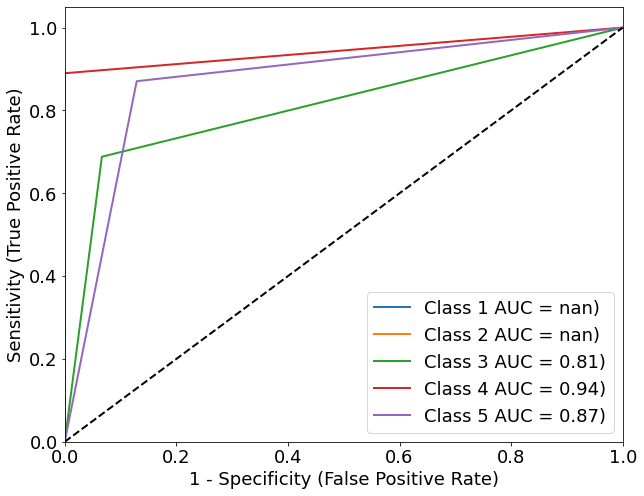

Sensitivity (TPR): 0.816(±0.182)
Specificity (TNR): 0.941(±0.094)
Precision (PPV): 0.647(±0.766)
Negative Predictive Value (NPV): 0.939(±0.078)
FPR: 0.059(±0.094)
FNR: 0.184(±0.182)
Accuracy: 0.916(±0.089)
Averaged AUC: 0.876(±0.110)


In [4]:
hemoCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoCardShockDeLvTx')

### Serial Cardiac

In [5]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/Hemo_Death')


*****MVDD Validation*****


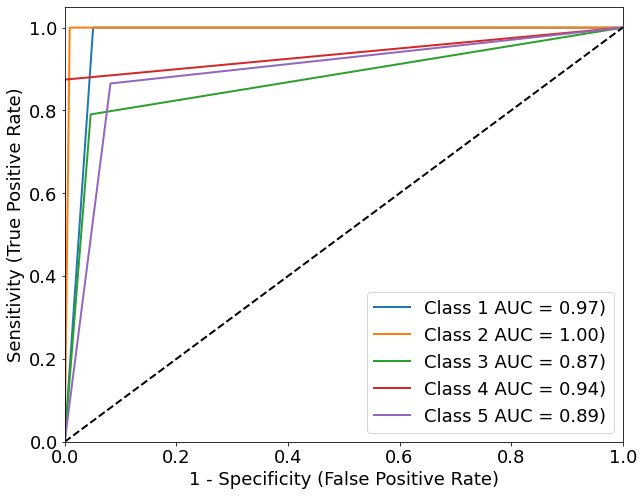

Sensitivity (TPR): 0.906(±0.164)
Specificity (TNR): 0.962(±0.060)
Precision (PPV): 0.607(±0.720)
Negative Predictive Value (NPV): 0.957(±0.071)
FPR: 0.038(±0.060)
FNR: 0.094(±0.164)
Accuracy: 0.940(±0.064)
Averaged AUC: 0.934(±0.094)


In [6]:
hemoCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv", sep=",", index_col='ID')
deathLabels = hemoCohort['ScoreDeath']

hemo = hemoCohort.drop('ScoreDeath', axis=1)
hemo = hemo.drop('Score', axis=1)
hemo = hemo.drop('ScoreRehosp', axis=1)
hemo = hemo.drop('ScoreReadmission', axis=1)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=hemo, realScores=deathLabels, aucName='HemoSerialCardiacDeLvTx')

# All Data Model Validation

## Label = All Outcomes
Note: only HF-Action has all outcome label

### HF-ACTION All Data Validation

In [7]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_AllOutcomes')


*****MVDD Validation*****


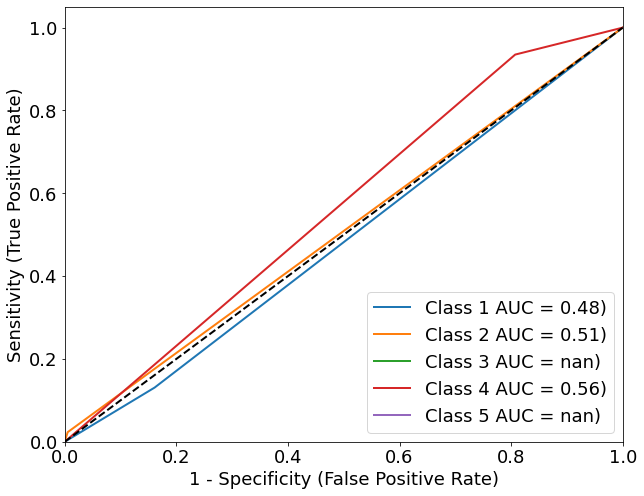

Sensitivity (TPR): 0.363(±0.814)
Specificity (TNR): 0.675(±0.694)
Precision (PPV): 0.435(±0.164)
Negative Predictive Value (NPV): 0.722(±0.335)
FPR: 0.325(±0.694)
FNR: 0.637(±0.814)
Accuracy: 0.565(±0.335)
Averaged AUC: 0.519(±0.066)


In [8]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['Score']

allD = guideAllData.drop('Score', axis=1)
allD = allD.drop('ScoreDeath', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFactionAll')

## Label = Death
Note: All Validation Datasets have the death label

### Cardiogenic Shock All Data Validation

In [9]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****


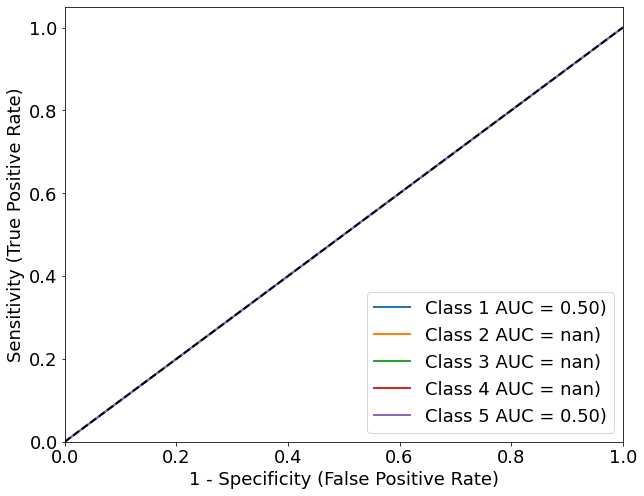

Sensitivity (TPR): 0.000(±0.000)
Specificity (TNR): 0.750(±0.860)
Precision (PPV): 0.000(±0.000)
Negative Predictive Value (NPV): 0.750(±0.771)
FPR: 0.250(±0.860)
FNR: 1.000(±0.000)
Accuracy: 0.500(±0.913)
Averaged AUC: 0.500(±0.000)


In [10]:
allDataCohort = pd.read_csv("Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataCardShockDeLvTx')

### Serial Cardiac All Data Validation

In [11]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****


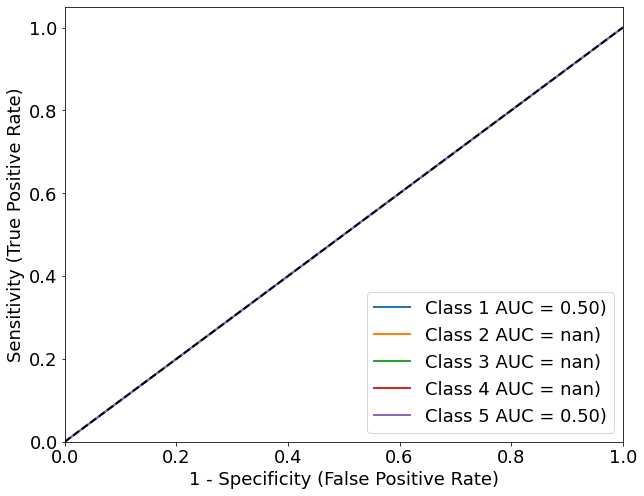

Sensitivity (TPR): 0.000(±0.000)
Specificity (TNR): 0.750(±0.794)
Precision (PPV): 0.000(±0.000)
Negative Predictive Value (NPV): 0.750(±0.716)
FPR: 0.250(±0.794)
FNR: 1.000(±0.000)
Accuracy: 0.500(±0.802)
Averaged AUC: 0.500(±0.000)


In [12]:
allDataCohort = pd.read_csv("Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv", sep=",", index_col='ID')
deathLabels = allDataCohort['ScoreDeath']

ad = allDataCohort.drop('ScoreDeath', axis=1)
ad = ad.drop('Score', axis=1)
ad = ad.drop('ScoreRehosp', axis=1)
ad = ad.drop('ScoreReadmission', axis=1)
ad = ad.replace(np.inf, 0)
ad = ad.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=ad, realScores=deathLabels, aucName='AllDataSerialCardiacDeLvTx')

### HF-ACTION All Data Validation

In [13]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****


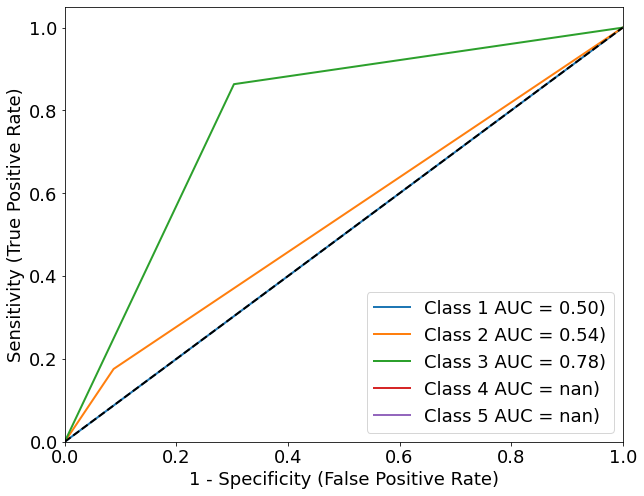

Sensitivity (TPR): 0.346(±0.745)
Specificity (TNR): 0.802(±0.321)
Precision (PPV): 0.405(±0.581)
Negative Predictive Value (NPV): 0.811(±0.362)
FPR: 0.198(±0.321)
FNR: 0.654(±0.745)
Accuracy: 0.672(±0.207)
Averaged AUC: 0.608(±0.246)


In [14]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataHFactionDeLvTx')

### BEST All Data Validation

In [15]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****


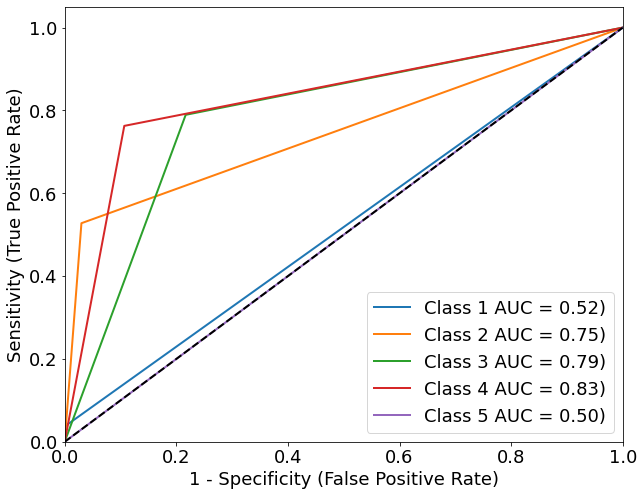

Sensitivity (TPR): 0.423(±0.686)
Specificity (TNR): 0.929(±0.166)
Precision (PPV): 0.557(±0.886)
Negative Predictive Value (NPV): 0.821(±0.696)
FPR: 0.071(±0.166)
FNR: 0.577(±0.686)
Accuracy: 0.901(±0.207)
Averaged AUC: 0.676(±0.278)


In [16]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataBestDeLvTx')

### GUIDE-IT All Data Validation

In [17]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Death')


*****MVDD Validation*****


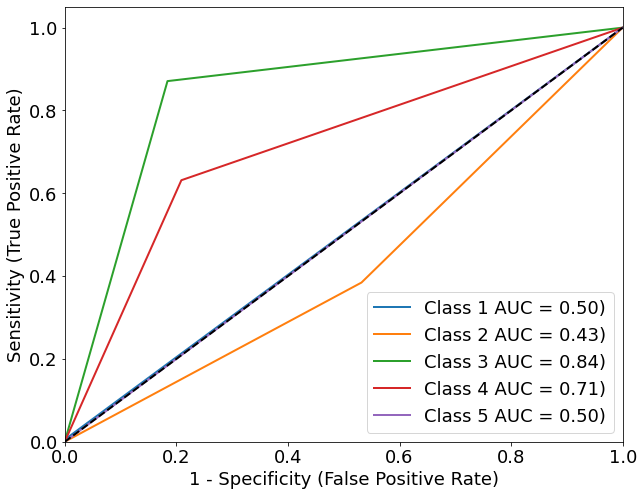

Sensitivity (TPR): 0.379(±0.686)
Specificity (TNR): 0.815(±0.388)
Precision (PPV): 0.395(±0.508)
Negative Predictive Value (NPV): 0.817(±0.416)
FPR: 0.185(±0.388)
FNR: 0.621(±0.686)
Accuracy: 0.719(±0.403)
Averaged AUC: 0.597(±0.311)


In [18]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
deathLabels = guideAllData['ScoreDeath']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=deathLabels, aucName='AllDataGuideItDeLvTx')

## Label = Rehospitalization
Note: Only HF-ACTION, BEST and GUIDE-IT have rehosp

### HF-ACTION All Data Validation

In [19]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****


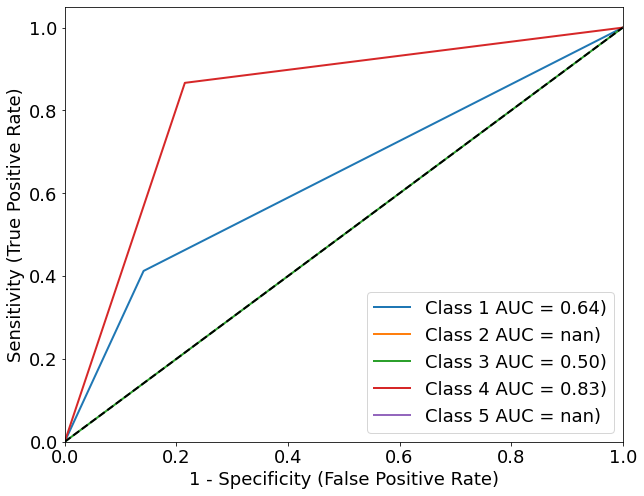

Sensitivity (TPR): 0.426(±0.708)
Specificity (TNR): 0.832(±0.229)
Precision (PPV): 0.458(±0.655)
Negative Predictive Value (NPV): 0.831(±0.312)
FPR: 0.168(±0.229)
FNR: 0.574(±0.708)
Accuracy: 0.732(±0.148)
Averaged AUC: 0.654(±0.267)


In [20]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFactionRehosp')

### BEST All Data Validation

In [21]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****


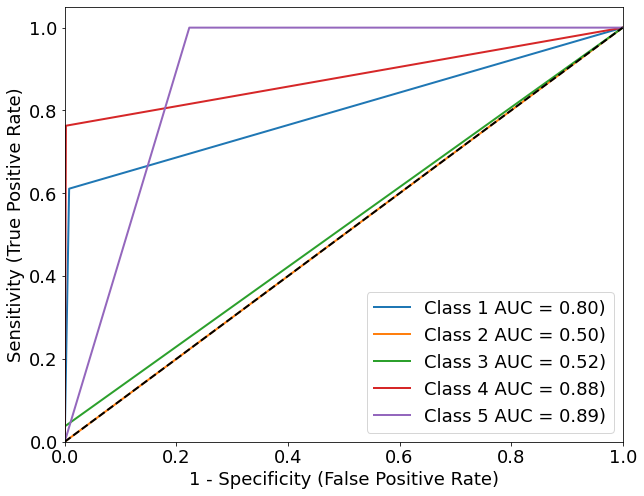

Sensitivity (TPR): 0.482(±0.797)
Specificity (TNR): 0.953(±0.177)
Precision (PPV): 0.830(±0.405)
Negative Predictive Value (NPV): 0.996(±0.007)
FPR: 0.047(±0.177)
FNR: 0.518(±0.797)
Accuracy: 0.993(±0.008)
Averaged AUC: 0.718(±0.346)


In [22]:
guideAllData = pd.read_csv("Data Validation/BEST/Preprocessed Data/BEST_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataBestRehosp')

### GUIDE-IT All Data Validation

In [23]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Rehosp')


*****MVDD Validation*****


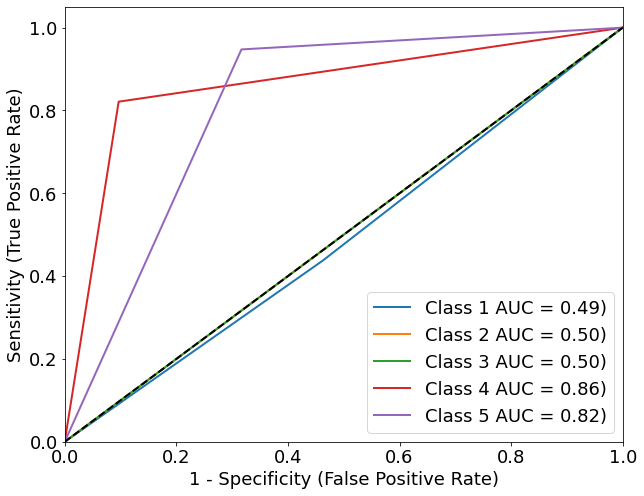

Sensitivity (TPR): 0.441(±0.795)
Specificity (TNR): 0.825(±0.369)
Precision (PPV): 0.343(±0.464)
Negative Predictive Value (NPV): 0.827(±0.394)
FPR: 0.175(±0.369)
FNR: 0.559(±0.795)
Accuracy: 0.724(±0.385)
Averaged AUC: 0.633(±0.337)


In [24]:
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreRehosp']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataGuideItRehosp')

## Label = Readmission
Note: only HF-ACTION has readm

### HF-ACTION All Data Validation

In [25]:
testModel = mvGen.loadMVDDFromFile('TreeFiles/AllData_Readmission')


*****MVDD Validation*****


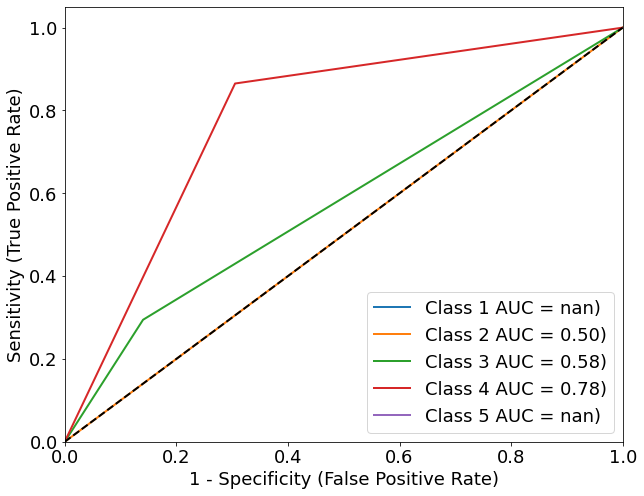

Sensitivity (TPR): 0.387(±0.718)
Specificity (TNR): 0.811(±0.258)
Precision (PPV): 0.407(±0.587)
Negative Predictive Value (NPV): 0.817(±0.344)
FPR: 0.189(±0.258)
FNR: 0.613(±0.718)
Accuracy: 0.702(±0.164)
Averaged AUC: 0.619(±0.236)


In [26]:
guideAllData = pd.read_csv("Data Validation/HF-ACTION/Preprocessed Data/HF-ACTION_AllData.csv", sep=",", index_col='ID')
labels = guideAllData['ScoreReadmission']

allD = guideAllData.drop('ScoreDeath', axis=1)
allD = allD.drop('Score', axis=1)
allD = allD.drop('ScoreRehosp', axis=1)
allD = allD.drop('ScoreReadmission', axis=1)
allD = allD.replace(np.inf, 0)
allD = allD.fillna(0)

#get predicted scores from model
performValidation(model=testModel, data=allD, realScores=labels, aucName='AllDataHFactionReadm')